In [545]:
## QICK LIBRARY
import sys
from qick import *
from qick.tprocv2_compiler import tprocv2_compile

from random import random
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [546]:
import logging
# logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.ERROR, force=True)

In [839]:
soc = QickSoc('../../qick_lib/qick/qick_4x2.bit')

print(soc)


QICK configuration:

	Board: RFSoC4x2

	Global clocks (MHz): tProcessor 350.000, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - tProc output 0, envelope memory 65536 samples
		DAC tile 0, blk 0, 32-bit DDS, fabric=614.400 MHz, f_dds=9830.400 MHz
	1:	axis_signal_gen_v6 - tProc output 1, envelope memory 65536 samples
		DAC tile 2, blk 0, 32-bit DDS, fabric=614.400 MHz, f_dds=9830.400 MHz

	2 readout channels:
	0:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, blk 0, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 16384 (avg) 1024 (decimated), trigger bit 4, tProc input 0
	1:	axis_readout_v2 - controlled by PYNQ
		ADC tile 0, blk 1, 32-bit DDS, fabric=491.520 MHz, fs=3932.160 MHz
		maxlen 16384 (avg) 1024 (decimated), trigger bit 5, tProc input 1

	2 DACs:
		DAC tile 0, blk 0 is DAC_B
		DAC tile 2, blk 0 is DAC_A

	2 ADCs:
		ADC tile 0, blk 0 is ADC_D
		ADC tile 0, blk 1 is ADC_C

	4 digital output pins (tProc output 0):
	0:	PMOD0_0
	1:	PMOD0_1


In [548]:
from collections import namedtuple, OrderedDict
from qick.qick_asm import AbsQickProgram

class Wave(namedtuple('Wave', ["freq", "phase", "env", "gain", "length", "conf"])):
    widths = [4, 4, 3, 4, 4, 2]
    def compile(self):
        # convert to bytes to get a 168-bit word (this is what actually ends up in the wave memory)
        rawbytes = b''.join([int(i).to_bytes(length=w, byteorder='little', signed=True) for i, w in zip(self, self.widths)])
        # pad with zero bytes to get the 256-bit word (this is the format for DMA transfers)
        paddedbytes = rawbytes[:11]+bytes(1)+rawbytes[11:]+bytes(10)
        # pack into a numpy array
        return np.frombuffer(paddedbytes, dtype=np.int32)

class QickProgramV2(AbsQickProgram):
    def __init__(self, soccfg):
        super().__init__(soccfg)
        self.prog_list = []
        self.labels = {}
        self.waves = OrderedDict()
        self.wave2idx = {}

    def add_instruction(self, inst):
        # copy the instruction dict, since it may be modified
        self.prog_list.append(inst.copy())

    def add_label(self, label):
        """apply the specified label to the next instruction
        """
        self.labels[label] = '&' + str(len(self.prog_list)+1)

    def add_wave(self, name, freq, phase, env, gain, length, conf):
        self.waves[name] = Wave(freq, phase, env, gain, length, conf)
        self.wave2idx[name] = len(self.waves)-1
        
    def pulse(self, ch, name, t=0):
        idx = self.wave2idx[name]
        tproc_ch = ch # TODO: actually translate
        self.add_instruction( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : str(t), 'UF':'0'  } )
        self.add_instruction( {'CMD':'WPORT_WR' , 'DST':str(tproc_ch)    ,'SRC':'wmem'   ,'ADDR':'&'+str(idx), 'UF':'0' } )

    def trigger(self, bits=255, t=0, width=10):
        # TODO: translate ROs+pins to bits
        self.add_instruction( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : str(t), 'UF':'0'  } )
        self.add_instruction( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'imm'   ,'LIT'  :str(bits), 'UF':'0' } )
        self.add_instruction( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : str(t+width), 'UF':'0'  } )
        self.add_instruction( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'imm'   ,'LIT'  :'0', 'UF':'0' } )

    def compile_prog(self):
        p_mem, _, _ = tprocv2_compile(self.prog_list, self.labels)
        return p_mem

    def compile_waves(self):
        if self.waves:
            return np.stack([w.compile() for w in self.waves.values()])
        else:
            return np.zeros((0,8), dtype=np.int32)

    def asm(self):
        _, _, asm = tprocv2_compile(self.prog_list, self.labels)
        return asm

    def config_all(self, soc):
        super().config_all(soc)
        soc.tproc.Load_PMEM(self.compile_prog())
        soc.tproc.load_mem(3, self.compile_waves())

In [809]:
def clear_reg():
    clear_prog = QickProgramV2(soc)

    clear_prog.add_instruction( {'CMD':"REG_WR" , 'DST':'s12'    ,'SRC':'imm'   ,'LIT'   : '0', 'UF':'0'  } )
    clear_prog.add_label('END')
    clear_prog.add_instruction( {'CMD':'JUMP'     , 'LABEL':'END', 'UF':'0' })

    clear_prog.config_all(soc)
#     print(clear_prog.asm())
    soc.tproc.reset()
    soc.tproc.run()
    print(soc.tproc.tproc_ext_dt1_o)

In [823]:
print(soc.tproc.read_mem(1,length=10))

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]


In [808]:
print(soc.tproc.status())

---------------------------------------------
--- Debug signals
EXT_MEM_ADDR :00010010
PMEM_ADDR    :00010001
Time Ref     :10100100

FIFO[0] Time :000FIFO_OK :1
Header  :000
---------------------------------------------
--- Memory Unit Status signals
AXI_Read  :0AXI_Write :0
ext_P_Mem_EN  :0ext_P_Mem_WEN :0
ext_D_Mem_EN  :0ext_D_Mem_WEN :0
ext_W_Mem_EN  :0ext_W_Mem_WEN :0
--- Processing Unit Status signals
FD0_Empty:1FD1_Empty:0FD0_Full:0FD1_Full:0
FW0_Empty:1FW1_Empty:1FW0_Full:0FW1_Full:0
PMEM_EN:1DMEM_WE:0WMEM_WE:0PORT_WE:0
T_en:1P_en:1STATE:001


In [830]:
prog = QickProgramV2(soc)
prog.declare_readout(ch=0, length=100, freq=200.0, gen_ch=0)

prog.add_wave("wave", soc.freq2reg(200.0, gen_ch=0, ro_ch=0),0,0,30000,20,9)

prog.add_instruction( {'CMD':'TIME'     , 'DST':'rst' } )
prog.add_instruction( {'CMD':'TIME'     , 'DST':'set_ref', 'LIT':'100' } )
prog.add_instruction( {'CMD':'TIME'     , 'DST':'inc_ref', 'LIT':'100' } )

prog.add_instruction( {'CMD':"REG_WR" , 'DST':'r0'    ,'SRC':'imm'   ,'LIT'   : '4', 'UF':'0'  } )
prog.add_label('CREATE_LOOP')

prog.pulse(ch=0, name="wave", t=0)
prog.pulse(ch=1, name="wave", t=0)

prog.trigger(bits=0xFF, t=100, width=10)

prog.add_instruction( {'CMD':'TIME'     , 'DST':'inc_ref', 'LIT':'500' } )
                     
prog.add_instruction( {'CMD':'JUMP'     , 'LABEL':'CREATE_LOOP', 'IF':'NZ', 'WR':'r0 op', 'OP':'r0-#1', 'UF':'1' })
                     
prog.add_instruction( {'CMD':"REG_WR" , 'DST':'s12'    ,'SRC':'imm'   ,'LIT'   : '17', 'UF':'0'  } )

prog.add_label('END')
prog.add_instruction( {'CMD':'JUMP'     , 'LABEL':'END', 'UF':'0' })

print(prog.waves)
print(prog.asm())
print(prog.compile_prog())

OrderedDict([('wave', Wave(freq=87381334, phase=0, env=0, gain=30000, length=20, conf=9))])
     TIME rst 
     TIME set_ref #100 
     TIME inc_ref #100 
     REG_WR r0 imm #4 
CREATE_LOOP:
     REG_WR s14 imm #0 
     WPORT_WR p0 wmem [&0] 
     REG_WR s14 imm #0 
     WPORT_WR p1 wmem [&0] 
     REG_WR s14 imm #100 
     DPORT_WR p0 imm #255 
     REG_WR s14 imm #110 
     DPORT_WR p0 imm #0 
     TIME inc_ref #500 
     JUMP CREATE_LOOP -if(NZ) -wr(r0 op) -op(r0-#1) -uf
     REG_WR s12 imm #17 
END:
     JUMP END 

[[0, 0, 0, 0, 0, 0, 0, 0], [0, 553648128, 232, 0, 0, 0, 0, 0], [12800, 1090519040, 236, 0, 0, 0, 0, 0], [12800, 2164260864, 236, 0, 0, 0, 0, 0], [512, 1610612736, 140, 0, 0, 0, 0, 0], [78, 1610612736, 140, 0, 0, 0, 0, 0], [0, 3221225472, 220, 0, 0, 0, 0, 0], [78, 1610612736, 140, 0, 0, 0, 0, 0], [0, 3221225600, 220, 0, 0, 0, 0, 0], [12878, 1610612736, 140, 0, 0, 0, 0, 0], [32640, 0, 204, 0, 0, 0, 0, 0], [14158, 1610612736, 140, 0, 0, 0, 0, 0], [0, 0, 204, 0, 0, 0, 0, 0],

In [840]:
clear_reg()
prog.config_all(soc)

while True:
    print("run")
    prog.config_bufs(soc, enable_avg=False, enable_buf=True)
    soc.tproc.reset()
    soc.tproc.run()
    time.sleep(0.1)
    val = soc.tproc.time_usr
    print(val)
    if val > 3:
        break
while True:
    val = soc.tproc.tproc_ext_dt1_o
    print(val)
    if val != 0:
        break
# soc.tproc.set_cond()
# soc.tproc.stop()

0
run
3
run
35052994
17


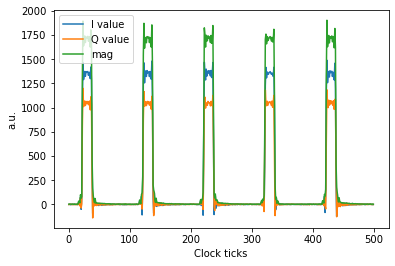

In [841]:
iq_list = [soc.avg_bufs[0].transfer_buf(length=500).T]

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
# plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()


In [534]:
print(soc.tproc.read_mem(1,length=10))
print(soc.tproc.read_mem(3,length=5))

[[0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0]]
[[43690666        0        0    30000       20        9        0        0]
 [       0        0        0        0        0        0        0        0]
 [       0        0        0        0        0        0        0        0]
 [       0        0        0        0        0        0        0        0]
 [       0        0        0        0        0        0        0        0]]


In [540]:
print(soc.tproc.PMEM_SIZE)
for i in tqdm(range(10000)):
    soc.tproc.load_mem(1,np.zeros((soc.tproc.PMEM_SIZE,8),dtype=np.int32))

1024


  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
print(soc.tproc.time_usr)
# print(soc.tproc.r_time)

In [ ]:
soc.tproc.info()

In [ ]:
print(soc.tproc)

In [ ]:
soc.tproc.getALL()

In [ ]:
soc.tproc.getStatus()

In [ ]:
def wavetest():
    prog_list = []
    Dict_Label = { 'r_addr':'s15'   }

    Dict_Label['WAIT_EC'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'START', 'IF':'EC', 'UF':'0' } )
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_EC', 'UF':'0' } )

    Dict_Label['START'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':"REG_WR" , 'DST':'r1'    ,'SRC':'op'   ,'OP'   : 'MSH s7', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'r2'    ,'SRC':'op'   ,'OP'   : 'LSH s7', 'UF':'0'  } )

    prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_CREATE_WAVES', 'UF':'0' } )
    prog_list.append( {'CMD':'TIME'     , 'DST':'rst' } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'  ,'LIT'  : '0', 'UF':'0'  } )
    prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_SHOW_WAVES', 'UF':'0' } )

    Dict_Label['WAIT_NEC'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_NEC', 'UF':'0' } )

    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_EC', 'UF':'0' } )

    Dict_Label['F_SHOW_WAVES'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':'TIME'     , 'DST':'set_ref', 'LIT':'100' } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'r0'    ,'SRC':'op'   ,'OP'   : 'r1-#1', 'UF':'1'  } )

    Dict_Label['SHOW_LOOP'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'op'   ,'OP'   : 's14+r2', 'UF':'0'  } )
    prog_list.append( {'CMD':'WPORT_WR' , 'DST':'4'    ,'SRC':'wmem'   ,'ADDR':'r0', 'UF':'0' } )
    prog_list.append( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'op'   ,'OP'  :'r0', 'UF':'0' } )
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'SHOW_LOOP', 'IF':'NZ', 'WR':'r0 op', 'OP':'r0-#1', 'UF':'1' } )

    prog_list.append( {'CMD':'RET'  } )


    Dict_Label['F_CREATE_WAVES'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':"REG_WR" , 'DST':'r0'    ,'SRC':'op'   ,'OP'   : 'r1-#1', 'UF':'1'  } )
    Dict_Label['CREATE_LOOP'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_RAND_WAVE', 'UF':'0' } )
    prog_list.append( {'CMD':'WMEM_WR'  , 'DST':'r0'   , 'UF':'0' } )
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'CREATE_LOOP', 'IF':'NZ', 'WR':'r0 op', 'OP':'r0-#1', 'UF':'1' } )
    prog_list.append( {'CMD':'RET'  } )

    Dict_Label['F_RAND_WAVE'] = '&' + str(len(prog_list)+1)
    #prog_list.append( {'CMD':"REG_WR" , 'DST':'w0'    ,'SRC':'imm'  ,'LIT'  : '1638400', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'r5'    ,'SRC':'op'   ,'OP'   : 's1>>#6', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w0'    ,'SRC':'op'   ,'OP'   : 'r5+#1638400', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w1'    ,'SRC':'imm'  ,'LIT'  : '0', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w2'    ,'SRC':'imm'  ,'LIT'  : '1', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w3'    ,'SRC':'imm'  ,'LIT'  : '30000', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w4'    ,'SRC':'imm'  ,'LIT'  : '430', 'UF':'0'  } )
    prog_list.append( {'CMD':"REG_WR" , 'DST':'w5'    ,'SRC':'imm'  ,'LIT'  : '17', 'UF':'0'  } )
    #prog_list.append( {'CMD':"REG_WR" , 'DST':'w1'    ,'SRC':'op'   ,'OP'   : 's1>>#1', 'UF':'0'  } )
    #prog_list.append( {'CMD':"REG_WR" , 'DST':'w3'    ,'SRC':'op'   ,'OP'   : 's1 AND #32767', 'UF':'0'  } )
    prog_list.append( {'CMD':'RET'  } )


    ## JUST IN CASE -Not Necesary
    Dict_Label['END'] = '&' + str(len(prog_list)+1)
    prog_list.append( {'CMD':'JUMP'     , 'LABEL':'END', 'UF':'0' } )

    pmem, PROG, asm = tprocv2_compile(prog_list, Dict_Label)

    return pmem, PROG, asm


In [ ]:
##### LOAD PROGRAM FROM FILE
#data_filename = "program_mem.pkl"
#print("Loading Program Memory From PICKLE File : " + data_filename)
#p_mem = pickle.load(open(data_filename, 'rb'))


## Program from script
p_mem, PROG, asm = wavetest()
soc.tproc.Load_PMEM(p_mem)

In [ ]:
print(asm)

In [ ]:
# from ctypes import *

# class Wave(Structure):
#     _pack_ = 1
#     _fields_ = [("freq", c_uint, 32),
#                 ("phase", c_uint, 32),
#                 ("env", c_uint, 24),
#                 ("gain", c_uint, 32),
#                 ("length", c_uint, 32),
#                 ("conf", c_uint16, 16)
#                ]
    
    
# class Flags(Union):
#     _fields_ = [("b", Wave),
#                 ("asbyte", 8*c_uint32)]
# print(Wave.gain)

# wave = Flags(Wave(1,2,3,4,5,6))
# print([hex(i) for i in list(wave.asbyte)])
# print(wave.b.gain)

In [ ]:
from collections import OrderedDict
a = OrderedDict()
a['foo'] = 17
a['bar'] = 19

In [ ]:
list(a.items())

In [ ]:
list(a.values())

In [ ]:
from collections import namedtuple

class Wave(namedtuple('Wave', ["freq", "phase", "env", "gain", "length", "conf"])):
    widths = [4, 4, 3, 4, 4, 2]
    def compile(self):
        # convert to bytes to get a 168-bit word (this is what actually ends up in the wave memory)
        rawbytes = b''.join([int(i).to_bytes(length=w, byteorder='little', signed=True) for i, w in zip(self, self.widths)])
        # pad with zero bytes to get the 256-bit word (this is the format for DMA transfers)
        paddedbytes = rawbytes[:11]+bytes(1)+rawbytes[11:]+bytes(10)
        # pack into a numpy array
        return np.frombuffer(paddedbytes, dtype=np.int32)

In [ ]:
soc.freq2reg(100.0, gen_ch=0, ro_ch=0)

In [ ]:
wave = Wave(soc.freq2reg(100.0, gen_ch=0, ro_ch=0),0,0,30000,20,9)
print(wave)

# waves = [wave, wave]
waves = [wave]
# waves_mem = np.frombuffer(b''.join([w.compile() for w in waves]), dtype=np.int32).reshape(-1,8)
waves_mem = np.stack([w.compile() for w in waves])
print(waves_mem)

soc.tproc.load_mem(3,waves_mem)
print(soc.tproc.read_mem(3,length=5))

In [ ]:
prog_list = []
Dict_Label = {}

prog_list.append( {'CMD':'TIME'     , 'DST':'inc_ref', 'LIT':'100' } )

prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : '0', 'UF':'0'  } )
prog_list.append( {'CMD':'WPORT_WR' , 'DST':'0'    ,'SRC':'wmem'   ,'ADDR':'&0', 'UF':'0' } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : '100', 'UF':'0'  } )
prog_list.append( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'imm'   ,'LIT'  :'255', 'UF':'0' } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'   ,'LIT'   : '110', 'UF':'0'  } )
prog_list.append( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'imm'   ,'LIT'  :'0', 'UF':'0' } )

prog_list.append( {'CMD':"REG_WR" , 'DST':'s12'    ,'SRC':'imm'   ,'LIT'   : '17', 'UF':'0'  } )

# Dict_Label['END'] = '&' + str(len(prog_list)+1)
# prog_list.append( {'CMD':'JUMP'     , 'LABEL':'END', 'UF':'0' } )

p_mem, PROG, asm = tprocv2_compile(prog_list, Dict_Label)
print(asm)

In [ ]:
soc.configure_readout(ch=0, output='product', frequency=100.0, gen_ch=0)
soc.config_buf(ch=0, length=200)
soc.tproc.Load_PMEM(p_mem)
soc.tproc.reset()
soc.tproc.run()
while True:
    val = soc.tproc.tproc_ext_dt1_o
    print(val)
    if val != 0:
        break
# soc.tproc.set_cond()
# soc.tproc.stop()

In [ ]:
iq_list = [soc.avg_bufs[0].transfer_buf(length=200).T]

# Plot results.
plt.figure(1)
for ii, iq in enumerate(iq_list):
    plt.plot(iq[0], label="I value")
    plt.plot(iq[1], label="Q value")
    plt.plot(np.abs(iq[0]+1j*iq[1]), label="mag")
plt.ylabel("a.u.")
plt.xlabel("Clock ticks")
# plt.title("Averages = " + str(config["soft_avgs"]))
plt.legend()


In [ ]:
print('TIME_USR: ', soc.tproc.time_usr)

## Program 
## ext_i1 (MSH) Indicates the AMOUNT of WAVES
## ext_i1 (LSH) Indicates the TIME BETWEEN WAVES

soc.tproc.tproc_cfg = 512
number_of_waves = 8
time_between_waves = 5

data = (number_of_waves << 16) + time_between_waves + 430
print(data)

soc.tproc.tproc_ext_dt1_i = data

soc.tproc.set_cond()

soc.tproc.reset()
soc.tproc.run()
soc.tproc.set_cond()
soc.tproc.stop()



In [ ]:
print(soc.tproc.read_mem(1, length=40))
print(soc.tproc.read_mem(3, length=10))


In [ ]:
soc.tproc.load_mem(1, np.ones((1,8),dtype=np.int32))
print(soc.tproc.read_mem(1, length=10))
soc.tproc.load_mem(1, np.ones((1,8),dtype=np.int32))

print(soc.tproc.read_mem(1, length=10))

soc.tproc.load_mem(1, 3*np.ones((1,8),dtype=np.int32))
print(soc.tproc.read_mem(1, length=10))

In [ ]:
# # # can only read 32 lowest bits using single read
# for i in range(soc.tproc.WMEM_SIZE):
#     soc.tproc.mem_addr = i
#     soc.tproc.tproc_cfg = 0x1D # read wmem
#     val = soc.tproc.mem_dt_o
#     soc.tproc.tproc_cfg = 0

#     if val != 0:
#         print(i, val)
        
# print(soc.tproc.read_mem(3, length=10))

# # can only read 32 lowest bits using single read
# for i in range(soc.tproc.PMEM_SIZE):
#     soc.tproc.mem_addr = i
#     soc.tproc.tproc_cfg = 0x15 # read pmem
#     val = soc.tproc.mem_dt_o
#     soc.tproc.tproc_cfg = 0

#     if val != 0:
#         print(i, val)
        
# print(soc.tproc.read_mem(1, length=20))

# for i in range(soc.tproc.DMEM_SIZE):
#     soc.tproc.mem_addr = i
#     soc.tproc.tproc_cfg = 0x15 # read dmem
#     val = soc.tproc.mem_dt_o
#     soc.tproc.tproc_cfg = 0
    
#     if val != 0:
#         print(i, val)
# print(soc.tproc.read_mem(2, length=20))


In [ ]:
# nsamp = 10

# prog = QickProgram(soccfg)
# prog.memri(1,1,123,"freq")
# prog.memri(1,2,124,"phase")
# prog.regwi(1,3,32000,"gain")
# prog.regwi(1,4,nsamp,"nsamp: generator will consume 16*nsamp DAC values.")
# prog.regwi(1,5,0x4,"b00100 -> phrst = 0, stdysel = 0, mode = 1, outsel = 00")
# prog.bitwi(1,5,5,"<<",16)
# prog.bitw(1,4,4,"|",5)
# prog.regwi(1,6,0,"start time")
# prog.synci(1000)
# prog.comment("Set trigger.")
# prog.regwi(0,1,0x1,"Send a pulse on pmod 0_0 (pin 1 on J48 on the ZCU111).")
# prog.seti(0,0,1,0,"Start the pulse.")
# prog.seti(0,0,0,100,"End the pulse after 100 ticks (260 ns).")

# prog.comment("Program signal generators in periodic mode.") #TODO: make comments sppear in the printout?
# prog.comment("Channels 4, 5, 6, 7 -> DAC 229 CH0/1/2/3.")
# for ch in out_chs:
#     # the channel number here is 1-indexed, since it's the tProc channel number for the gen
#     prog.set(ch+1,1,1,2,0,3,4,6)
# prog.synci(1000)
# prog.comment("Set trigger.")
# prog.regwi(0,1,0xc000,"Trigger both buffers.")
# prog.seti(0,0,1,0,"Start the pulse.")
# prog.seti(0,0,0,100,"End the pulse after 100 ticks (260 ns).")
# prog.end()

# print(prog)

# prog.load_program(soc)

# # Constant, real envelope.
# # The length must be at least 16 times the nsamp parameter passed to the signal generators.
# xg = np.zeros((16*nsamp,2), dtype=np.int16)
# xg[:,0] = 30000

# for ch in out_chs:
#     # Set the DAC channels to be in 1st Nyquist zone mode
#     soc.set_nyquist(ch=ch,nqz=1)
#     # Upload waveform.
#     soc.load_pulse_data(ch=ch, data=xg, addr=0)

# # Output phase.
# fi0 = 0

# fi_v = np.zeros((2,len(f0_v)))

# # Load program.
# for ii, f0 in enumerate(f0_v):
#     measure_phase_decimated(soc, f0, fi0, fi_v[:,ii])

# soc.reset_gens()

### bugs?

In [ ]:
soc.tproc.mem_addr = 0
soc.tproc.tproc_cfg = 0x1F # write wmem
soc.tproc.mem_dt_i = 17
soc.tproc.tproc_cfg = 0

soc.tproc.read_mem(3, length=10) # this hangs; killing this and trying again gives "DMA channel not idle"

In [ ]:
dummy_mem = np.ones((1,8),dtype=np.int32)

soc.tproc.Load_PMEM(dummy_mem)

soc.tproc.mem_addr = 0
soc.tproc.tproc_cfg = 0x15 # read pmem
val = soc.tproc.mem_dt_o
soc.tproc.tproc_cfg = 0

print(soc.tproc.read_mem(1, length=10))

soc.tproc.Load_PMEM(dummy_mem) # hangs, DMA "not started"

In [ ]:
soc.tproc.load_mem(1, np.ones((1,8),dtype=np.int32)) # write 1s to pmem address 0
print(soc.tproc.read_mem(1, length=10)) # looks correct

soc.tproc.mem_addr = 0
soc.tproc.tproc_cfg = 0x15 # read pmem
val = soc.tproc.mem_dt_o
soc.tproc.tproc_cfg = 0
print(soc.tproc.read_mem(1, length=10)) # why is the data repeated 5 times?

In [ ]:
prog_list = []
Dict_Label = { 'r_addr':'s15'   }

Dict_Label['WAIT_EC'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'START', 'IF':'EC', 'UF':'0' } )
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_EC', 'UF':'0' } )

Dict_Label['START'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':"REG_WR" , 'DST':'r1'    ,'SRC':'op'   ,'OP'   : 'MSH s7', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'r2'    ,'SRC':'op'   ,'OP'   : 'LSH s7', 'UF':'0'  } )

prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_CREATE_WAVES', 'UF':'0' } )
prog_list.append( {'CMD':'TIME'     , 'DST':'rst' } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'imm'  ,'LIT'  : '0', 'UF':'0'  } )
prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_SHOW_WAVES', 'UF':'0' } )

Dict_Label['WAIT_NEC'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_NEC', 'UF':'0' } )

prog_list.append( {'CMD':'JUMP'     , 'LABEL':'WAIT_EC', 'UF':'0' } )

Dict_Label['F_SHOW_WAVES'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':'TIME'     , 'DST':'set_ref', 'LIT':'100' } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'r0'    ,'SRC':'op'   ,'OP'   : 'r1-#1', 'UF':'1'  } )

Dict_Label['SHOW_LOOP'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':"REG_WR" , 'DST':'s14'    ,'SRC':'op'   ,'OP'   : 's14+r2', 'UF':'0'  } )
prog_list.append( {'CMD':'WPORT_WR' , 'DST':'4'    ,'SRC':'wmem'   ,'ADDR':'r0', 'UF':'0' } )
prog_list.append( {'CMD':'DPORT_WR' , 'DST':'0'    ,'SRC':'op'   ,'OP'  :'r0', 'UF':'0' } )
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'SHOW_LOOP', 'IF':'NZ', 'WR':'r0 op', 'OP':'r0-#1', 'UF':'1' } )

prog_list.append( {'CMD':'RET'  } )


Dict_Label['F_CREATE_WAVES'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':"REG_WR" , 'DST':'r0'    ,'SRC':'op'   ,'OP'   : 'r1-#1', 'UF':'1'  } )
Dict_Label['CREATE_LOOP'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':'CALL'     , 'LABEL':'F_RAND_WAVE', 'UF':'0' } )
prog_list.append( {'CMD':'WMEM_WR'  , 'DST':'r0'   , 'UF':'0' } )
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'CREATE_LOOP', 'IF':'NZ', 'WR':'r0 op', 'OP':'r0-#1', 'UF':'1' } )
prog_list.append( {'CMD':'RET'  } )

Dict_Label['F_RAND_WAVE'] = '&' + str(len(prog_list)+1)
#prog_list.append( {'CMD':"REG_WR" , 'DST':'w0'    ,'SRC':'imm'  ,'LIT'  : '1638400', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'r5'    ,'SRC':'op'   ,'OP'   : 's1>>#6', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w0'    ,'SRC':'op'   ,'OP'   : 'r5+#1638400', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w1'    ,'SRC':'imm'  ,'LIT'  : '0', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w2'    ,'SRC':'imm'  ,'LIT'  : '1', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w3'    ,'SRC':'imm'  ,'LIT'  : '30000', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w4'    ,'SRC':'imm'  ,'LIT'  : '430', 'UF':'0'  } )
prog_list.append( {'CMD':"REG_WR" , 'DST':'w5'    ,'SRC':'imm'  ,'LIT'  : '17', 'UF':'0'  } )
#prog_list.append( {'CMD':"REG_WR" , 'DST':'w1'    ,'SRC':'op'   ,'OP'   : 's1>>#1', 'UF':'0'  } )
#prog_list.append( {'CMD':"REG_WR" , 'DST':'w3'    ,'SRC':'op'   ,'OP'   : 's1 AND #32767', 'UF':'0'  } )
prog_list.append( {'CMD':'RET'  } )


## JUST IN CASE -Not Necesary
Dict_Label['END'] = '&' + str(len(prog_list)+1)
prog_list.append( {'CMD':'JUMP'     , 'LABEL':'END', 'UF':'0' } )

# tprocv2_getasm(prog_list, Dict_Label);

pmem, PROG, asm = tprocv2_compile(prog_list, Dict_Label)

### don't look below

In [ ]:
# #soc.tproc.reset()
# soc.tproc.tproc_ctrl      = 32 # tProc Step (Time and Core Increase 1 step)
# soc.tproc.getStatus()

In [ ]:
# soc.tproc.reset()


In [ ]:
# soc.tproc.tproc_ctrl      = 1 # RST
# soc.tproc.tproc_ctrl      = 16

In [ ]:
# Load_Program(soc)

# soc.tproc.tproc_ctrl      = 1 # RST
# soc.tproc.tproc_ctrl      = 16 # PLAY
# soc.tproc.tproc_ext_dt2_i = 0 #READ 2

# soc.tproc.tproc_ext_dt1_i = 0 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 1 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 2 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 3 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 4 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 4 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)
# soc.tproc.tproc_ext_dt1_i = 25 #READ 2
# soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION
# getALL(soc)


# # Micro CONTROL Values
# #soc.tproc.tproc_ctrl      = 1 # RST
# #soc.tproc.tproc_ctrl      = 2 # STOP
# #soc.tproc.tproc_ctrl      = 4 # Core PAUSE (Time RUN)
# #soc.tproc.tproc_ctrl      = 8 # Time Freeze (Core RUN)
# #soc.tproc.tproc_ctrl      = 16 # PLAY
# #soc.tproc.tproc_ctrl      = 32 # tProc Step (Time and Core Increase 1 step)
# #soc.tproc.tproc_ctrl      = 64 # Core STEP (Time STOP)
# #soc.tproc.tproc_ctrl      = 128 # Time STEP (Core STOP)
# #soc.tproc.tproc_ctrl      = 1024 # Set CONDITION
# #soc.tproc.tproc_ctrl      = 2048 # Clear CONDITION

# #getState(soc)
# #getStatus(soc)

# t1 = soc.tproc.time_usr
# soc.tproc.tproc_ext_dt1_i = 25 #READ 2
# a = soc.tproc.tproc_ext_dt2_o
# t2 = soc.tproc.time_usr
# print('First Read : ', t1, 'Second Read : ', t2)
# t_clk = t2 - t1

# t_us = int(soccfg.cycles2us(t_clk, gen_ch=0)*1000)/1000
# print('Time Elapsed : ' + str(  t_us ) +  'us')
# print('Time Single  : ' + str( (t_us/3)) +  'us')

      

In [ ]:
# getStatus(soc)
# soc.tproc.tproc_ctrl      = 1
# getStatus(soc)
# soc.tproc.tproc_ctrl      = 128 # Time STEP (Core STOP)
# getStatus(soc)

# print('----- RUNNING')
# soc.tproc.tproc_ctrl      = 16
# getStatus(soc)
# time.sleep(1)
# getStatus(soc)

# print('-----Reset')
# #soc.tproc.tproc_ctrl      = 2
# #getStatus(soc)


# a = soc.tproc.time_usr
# print('TIME_USR: ', a)
# soc.tproc.tproc_ctrl      = 32 # tProc Step (Time and Core Increase 1 step)
# a = soc.tproc.time_usr
# print('TIME_USR: ', a)

In [ ]:
# #####################################################################
# ## INFO
# soccfg = QickConfig(soc)
# print(soccfg)
# print(soc)

# #soc.ip_dict.keys()
# soc.tproc.PMEM_SIZE
# soc.tproc.DMEM_SIZE
# soc.tproc.WMEM_SIZE
# soc.tproc.DREG_QTY
# soc.tproc.IN_PORT_QTY
# soc.tproc.OUT_DPORT_QTY
# soc.tproc.OUT_WPORT_QTY

# soc.tproc.info()

# from pynq import Clocks
# print("CPU CLK : " + str(Clocks.cpu_mhz) + "Mhz")
# print("PL0  CLK : " + str(Clocks.fclk0_mhz) + "Mhz")
# print("PL1  CLK : " + str(Clocks.fclk1_mhz) + "Mhz")
# print("PL2  CLK : " + str(Clocks.fclk2_mhz) + "Mhz")
# print("PL3  CLK : " + str(Clocks.fclk3_mhz) + "Mhz")
# #print("ADC CLK : " + str(soc.fs_adc)  + "Mhz")
# #print("DAC CLK : " + str(soc.fs_dac)  + "Mhz\n")

# #period_ms = 1 / Clocks.fclk0_mhz /1000

# BUFF_SIZE     = 256
# mem_buff_bytes = (BUFF_SIZE) * 256 /1024
# print("Allocate Buffer Size:" , mem_buff_bytes, "KBytes")
# dma_buff_bytes = soc.axi_dma_tproc.buffer_max_size /1024
# print("DMA Buffer Size     :" , dma_buff_bytes, "KBytes")

In [ ]:
soc.dacs